# Importing the important libraries

In [105]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
import re

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


# Read Corpus:
For reading the reuters dataset

# Tokens:
To indicate the start and end of sentences

In [0]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'
def read_corpus(category="crude"):
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

# Distinct words:
This function takes the corpus as input and do the following sequentially: 


1.   Remove any non-alphabetic characters and keep < START > < END >
2.   Insert the sentences in a "SET" as the "SET" data structure removes duplicates so we keep track of unique words
3.   Order the words alphabetically
4.   Return the count to know our vocabulary size




In [0]:
def distinct_words(corpus):
    corpus_words = []
    num_corpus_words = -1
    distinct_set = set()
    for sentence in corpus:
          #Remove the non-alphabetic characters because they are alot
          regex = re.compile(r'[^\<\>a-zA-Z]')
          sentence = [i for i in sentence if not regex.match(str(i))]
          distinct_set.update(sentence)
    corpus_words = list(distinct_set)
    num_corpus_words = len(distinct_set)
    # The test words was in order so this the need for the .sort()
    corpus_words.sort()
    return corpus_words, num_corpus_words

# Co-occurence Matrix:
This matrix is constructed by checking the outside words the co-occured with a certain word in a certain window size like for example:
Paul is a good guy and he is awesome.
Center word : good, Outside words with window size = 2 : is,a -> left window guy ,and -> right window

In [0]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words,num_words))
    word2Ind = {}
    Ind2word = {}
    for i, word in enumerate(words):
        word2Ind[word] = i
        Ind2word[i] = word
    for sentence in corpus:
        regex = re.compile(r'[^\<\>a-zA-Z]')
        sentence = [i for i in sentence if not regex.match(i)]
        for i,word in enumerate(sentence):
            center_word_id = word2Ind[word]
            window_ids = list(range(max(0,i - window_size),i)) + list(range(i+1,min(i+window_size+1,len(sentence))))
            for j in window_ids:
                out_word = sentence[j]
                out_word_id = word2Ind[out_word]
                M[center_word_id][out_word_id] += 1
    
    return M, word2Ind, Ind2word

# Create the dataset for the model where each X corresponds to the center word and each Y corresponds to a context word corresponding to that center word

In [0]:
def Create_Dataset(word2Ind,tokens,window_size=4):
    X,Y = [],[]
   
    for line in tokens:
        regex = re.compile(r'[^\<\>a-zA-Z]')
        line = [k for k in line if not regex.match(k)]
        N = len(line)
        for i,word in enumerate(line):
            window = list(range(max(0,i-window_size),i)) + list(range(i+1,min(i+window_size+1,N)))
            for j in window:
              X.append(word2Ind[line[i]])
              Y.append(word2Ind[line[j]])
            
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

# Create the embedding matrices for W_i and W_j , center words and context words matrices respectively

In [0]:
def create_center_word_matrix(Vocab_size,Embed_size):
    return np.random.randn(Vocab_size,Embed_size) * 0.01
  
def create_context_word_matrix(Vocab_size,Embed_size):
    return np.random.randn(Embed_size,Vocab_size) * 0.01
  
def create_bias_center_word(Vocab_size):
    return np.random.randn(Vocab_size) * 0.01

def create_bias_out_word(Vocab_size):
    return np.random.randn(Vocab_size) * 0.01
    
def create_weight_matrices(Vocab_size,Embed_size):
    Weight_Parameters = {}
    bias_Parameters = {}
    Weight_Parameters['Center'] = create_center_word_matrix(Vocab_size,Embed_size)
    Weight_Parameters['Context'] = create_context_word_matrix(Vocab_size,Embed_size)
    bias_Parameters['Center'] = create_bias_center_word(Vocab_size)
    bias_Parameters['Context'] = create_bias_out_word(Vocab_size)
    return Weight_Parameters, bias_Parameters

# This part is according to the paper weighting factor $
\begin{aligned}
    \textit{f}({X_{ij}}) &= (x / x_{max}) ^\alpha  \ if x < x_{max}\\        
     &=  1 \ otherwise
  \end{aligned}$


In [0]:
def Weightening_function(cooccurence_matrix,Center_word,Out_word,X_max = 100,alpha=0.75):
    X = cooccurence_matrix[Center_word,Out_word]
    if X > X_max: 
      return 1
    elif X_max >= X:
      eq = (X/X_max) ** alpha
      return eq
    
def dot_product_add_bias(Center_word,Out_word,W_Parameters,b_Parameters):
    W_C_matrix,W_O_matrix = W_Parameters['Center'],W_Parameters['Context']
    b_C , b_O = b_Parameters['Center'], b_Parameters['Context']
    Dot_product = np.dot(W_C_matrix[Center_word,:],W_O_matrix[:,Out_word])
    return Dot_product + b_C[Center_word] + b_O[Out_word]

# Forward Pass

In [0]:
def Forward(cooccurence_matrix,Center_word,Out_word,W_Parameters, b_Parameters,Embed_size):
    F = Weightening_function(cooccurence_matrix,Center_word,Out_word)
    Skip_gram_part = dot_product_add_bias(Center_word,Out_word,W_Parameters, b_Parameters)
    Co_occurence_part = cooccurence_matrix[Center_word,Out_word]
    Difference = Skip_gram_part - np.log(Co_occurence_part)
    return F,Difference

# Derivatives 
$
J = \sum\sum\textit{f}({X_{ij}}) (w_iw_j^T + b_i + b_j- \log{X_{ij}})^2
\\
\frac{\partial J}{\partial w_i} = w_j \textit{f}({X_{ij}}) (w_iw_j^T + b_i + b_j- \log{X_{ij}})
\\
\frac{\partial J}{\partial w_j} = w_i \textit{f}({X_{ij}}) (w_iw_j^T + b_i + b_j- \log{X_{ij}})
\\
\frac{\partial J}{\partial b_i} = \textit{f}({X_{ij}}) (w_iw_j^T + b_i + b_j- \log{X_{ij}})
\\
\frac{\partial J}{\partial b_j}= \textit{f}({X_{ij}}) (w_iw_j^T + b_i + b_j- \log{X_{ij}})
$

In [0]:
def Weight_i_Derivative(W_Parameters,F,Difference,Out_word):
    W_J = W_Parameters['Context'][:,Out_word]
    return W_J * F * Difference
  
def Weight_j_Derivative(W_Parameters,F,Difference,Center_word):
    W_I = W_Parameters['Center'][Center_word,:]
    return W_I * F * Difference

def Bias_i_j_Derivative(F,Difference):
    return F * Difference

# Update Parameters is the gradient descent step
$
w_i = w_i - \alpha \frac{\partial J}{\partial w_i} \\
w_j = w_j - \alpha \frac{\partial J}{\partial w_j} \\
b_i = b_i - \alpha \frac{\partial J}{\partial b_i} \\
b_j = b_j - \alpha \frac{\partial J}{\partial b_j} 
$

In [0]:
def Compute_Derivative(W_Parameters,F,Difference,Center_word,Out_word):
    Caches = {}
    d_W_I = Weight_i_Derivative(W_Parameters,F,Difference,Out_word)
    d_W_J = Weight_j_Derivative(W_Parameters,F,Difference,Center_word)
    
    d_b_I = Bias_i_j_Derivative(F,Difference)
    d_b_J = Bias_i_j_Derivative(F,Difference)
    
    Caches['d_W_I'] = d_W_I
    Caches['d_W_J'] = d_W_J
    Caches['d_b_I'] = d_b_I
    Caches['d_b_J'] = d_b_J
    return Caches

def Loss(F,Difference):
    return F * (Difference**2)
  
def Update_Parameters(W_Parameters,b_Parameters,Center_word,Out_word,F,Difference,learning_rate):
    
    Caches = Compute_Derivative(W_Parameters,F,Difference,Center_word,Out_word)
    
    W_I = W_Parameters['Center']
    W_J = W_Parameters['Context']
    B_I = b_Parameters['Center']
    B_J = b_Parameters['Context']
    
    w_i = W_I[Center_word,:]
    w_j = W_J[:,Out_word]
    b_i = B_I[Center_word]
    b_j = B_J[Out_word]
    
    w_i = w_i - learning_rate * Caches['d_W_I']
    w_j = w_j - learning_rate * Caches['d_W_J']
    b_i = b_i - learning_rate * Caches['d_b_I']
    b_j = b_j - learning_rate * Caches['d_b_J']
    
    W_Parameters['Center'][Center_word,:] = w_i
    W_Parameters['Context'][:,Out_word] = w_j
    b_Parameters['Center'][Center_word] = b_i
    b_Parameters['Context'][Out_word] = b_j

In [0]:
def Train(Epochs,Embed_size,learning_rate):
    corpus = read_corpus()
    _ , vocab_size = distinct_words(corpus)
    W_Parameters, b_Parameters = create_weight_matrices(vocab_size,Embed_size)
    M, word2Ind, Ind2word = compute_co_occurrence_matrix(corpus)
    template = "Epoch {} : Loss is {}"
    X,Y = Create_Dataset(word2Ind,corpus)
    losses = []
    for Epoch in range(Epochs):
        loss = 0
        for center_word,out_word in zip(X,Y):
            F, Difference = Forward(M,center_word,out_word,W_Parameters,b_Parameters,Embed_size)
            loss = loss + Loss(F,Difference)
            Update_Parameters(W_Parameters,b_Parameters,center_word,out_word,F,Difference,learning_rate)
        
        losses.append(loss/len(X))
        print(template.format(Epoch+1,
                             loss/len(X)))
    return losses,W_Parameters   

In [187]:
losses,W_Parameters=Train(20,300,0.1)

Epoch 1 : Loss is 0.03914038243948939
Epoch 2 : Loss is 0.014211566302360713
Epoch 3 : Loss is 0.010233110098059103
Epoch 4 : Loss is 0.008203713622388685
Epoch 5 : Loss is 0.0069180025300665405
Epoch 6 : Loss is 0.0059978719350842575
Epoch 7 : Loss is 0.005312295793822118
Epoch 8 : Loss is 0.00478576024378802
Epoch 9 : Loss is 0.004358549467366621
Epoch 10 : Loss is 0.0039962364756629
Epoch 11 : Loss is 0.0036887386080486904
Epoch 12 : Loss is 0.003419047387276843
Epoch 13 : Loss is 0.0031838669935071316
Epoch 14 : Loss is 0.0029782962115046372
Epoch 15 : Loss is 0.0027977994886596363
Epoch 16 : Loss is 0.0026506704841303035
Epoch 17 : Loss is 0.0024936099573012183
Epoch 18 : Loss is 0.002379360689734717
Epoch 19 : Loss is 0.0022350380061435518
Epoch 20 : Loss is 0.0021390386386778244


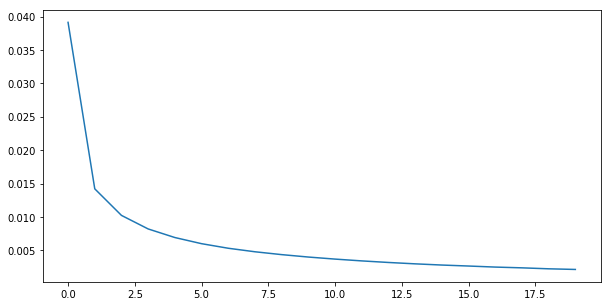

In [188]:
plt.figure()
plt.plot(losses)
plt.show()

In [189]:
corpus = read_corpus()
M, word2Ind, Ind2word = compute_co_occurrence_matrix(corpus)
Total_W_Parameters = (W_Parameters['Center'] + W_Parameters['Context'].T)/2
Total_W_Parameters.shape

(7597, 300)

In [204]:
print(np.dot(Total_W_Parameters[word2Ind['oil'],:],Total_W_Parameters[word2Ind['petroleum'],:]))

2.3263744171773086

In [209]:
print(np.dot(Total_W_Parameters[word2Ind['water'],:],Total_W_Parameters[word2Ind['island'],:]))

-0.04208639632028421
